## Identification Rate Metric

При обучении модели для распознавания лиц с помощью CE (кросс-энтропии) мы можем считать метрику accuracy как индикатор того, насколько хорошо наша модель работает. Но у accuracy тут есть недостаток: она не сможет померить, насколько хорошо наша модель работает на лицах людей, которых нет в обучающей выборке.  

Чтобы это исправить, придумали новую метрику: **identification rate**. Вот как она работает:

Создадим два набора изображений лиц: query и distractors. Никакие лица из этих наборов не должны содержаться в обучающем и валидационном датасете.

1. Посчитаем косинусные сходства между лицами, соответствующими одним и тем же людям из query части. Например, пусть одному человеку соответствуют три фото в query: 01.jpg, 02.jpg, 03.jpg. Тогда считаем три косинусных сходства между всеми тремя парами из этих фото.
2. Посчитаем косинусные сходства между лицами, соответствующими разным людям из query части.
3. Посчитаем косинусные сходства между всеми парами лиц из query и distractors. Т.е. пара — это (лицо из query, лицо из distractors). Всего получится |query|*|distractors| пар.
4. Сложим количества пар, полученных на 2 и 3 шагах. Это количество false пар.
5. Зафиксируем **FPR** (false positive rate). Пусть, например, будет 0.01. FPR, умноженный на количество false пар из шага 4 — это разрешенное количество false positives, которые мы разрешаем нашей модели. Обозначим это количество через N.
6. Отсортируем все значения косинусных сходств false пар в порядке убывания. N — ое значение расстояния зафиксируем как **пороговое расстояние**.
7. Посчитаем количество positive пар с шага 1, которые имеют косинусное сходство больше, чем пороговое расстояние. Поделим это количество на общее количество positive пар с шага 1. Это будет TPR (true positive rate) — итоговое значение нашей метрики.

Такая метрика обычно обозначается как TPR@FPR=0.01. FPR может быть разным. Приразных FPR будет получаться разное TPR.

Смысл этой метрики в том, что мы фиксируем вероятность ошибки вида false positive, т.е. когда "сеть сказала, что это один и тот же человек, но это не так", считаем порог косинусного сходства для этого значения ошибки, потом берем все positive пары и смотрим, у скольких из них сходство меньше этого порога. Т.е. насколько точно наша сеть ищет похожие лица при заданной вероятности ошибки вида false positive.

**Для подсчета метрик, то вам нужно разбить данные на query и distractors самим.**

Делается это примерно так:
- Выбраете несколько id, которые не использовались при тренировке моделей, и помещаете их в query set;
- Выбираете несколько id, которые не использовались при тренировке моделей и не входят в query, и помещаете их в distractors set. Обычно distractors set должен быть сильно больше, чем query set.
- Обрабатываете картинки из query и distractors тем же способом, что картинки для обучения сети.


Обратите внимание, что если картинок в query и distractors очень много, то полученных пар картинок в пунктах 1-2-3 алгоритма подсчета TPR@FPR будет очень-очень много. Чтобы код подсчета работал быстрее, ограничивайте размеры этих датасетов. Контролируйте, сколько значений расстояний вы считаете.

Ниже дан шаблон кода для реализации FPR@TPR метрики и ячейки с тестами. Тесты проверяют, что ваш код в ячейках написан правильно.

### План заданий

* Правильно разбить датасет на query и distractors
* Реализовать метрику и пройти все тесты
* Подгрузить все модели, обученные на разных лоссах и сравнить их метрики

## Импорт библиотек, инициализация моделей, загрузка данных

In [2]:
import numpy as np
import pandas as pd
import math

import torch
import torch.nn.functional as F
import torch.nn as nn

from sklearn.metrics import auc

from PIL import Image
from torchvision import transforms
from itertools import combinations

import os
import random

from matplotlib import pyplot as plt
import csv
from pathlib import Path

In [3]:
os.getcwd()

'/home/alex/Downloads/DLS-1_autumn 2025-FR_project/to_GitHub/notebooks'

In [1]:
import sys
sys.path.append('..')  # этот ноутбук должен находиться в папке notebooks

from src.models import FRModel, FRModel_ArcFace, EmbeddingModel

In [4]:
# устанавливаем ядра рандомов
RANDOM_SEED = 4242
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {DEVICE}")




dir_dataset = '../data_CelebA_mini'  # папка для уменьшенного датасета
dir_aligned = f'{dir_dataset}/data_aligned'  # папка для выровненных изображений уменьшенного датасета

base_dir = f'{dir_dataset}/data_fr' # папка для формирования датасета для распознавания лиц (физическое разделение изображений)
ident_dir = f'{dir_dataset}/data_IRM' # папка для реализации Identification Rate Metric
dir_metadata_fr = f'{dir_dataset}/metadata_fr' # папка для метаданных для распознавания лиц


# файл метаданных
metadata_aligned = f'{dir_dataset}/list_attr_celeba_mini.csv'


# папки для обучения
train_dir = f'{base_dir}/train'
val_dir = f'{base_dir}/val'
test_dir = f'{base_dir}/test'
# папки для identification rate
query_dir = f'{ident_dir}/query'
distractors_dir = f'{ident_dir}/distractors'


dir_checkpoints = 'checkpoints' # папка для сохранения чекпоинтов

Используемое устройство: cuda


### Инициализируем модели, загружаем лучшие веса

In [ ]:
num_classes = 440
embedding_size = 1024


best_model_ce_path = "../checkpoints/model_fr_ce_20260125_231417_epoch_38_val_0.7621.pth"
best_model_ce = FRModel(num_classes=num_classes).to(DEVICE) # создаем модель
checkpoint = torch.load(best_model_ce_path, map_location=DEVICE, weights_only=True) # загружаем состояние модели
best_model_ce.load_state_dict(checkpoint['model_state_dict']) # загружаем веса модели
best_model_ce.eval()



best_model_arcface_path = "../checkpoints/arcface_model_20260126_163544_epoch_38_val_0.7848.pth"
best_model_arcface = FRModel_ArcFace(num_classes=num_classes, embedding_size=embedding_size).to(DEVICE)
checkpoint = torch.load(best_model_arcface_path, map_location=DEVICE, weights_only=True)
best_model_arcface.load_state_dict(checkpoint['model_state_dict'])
best_model_arcface.eval()



best_model_triplet_path = "../checkpoints/triplet_best_epoch_20260131_2225_epoch_12_val_0.7967.pth"
best_model_triplet = EmbeddingModel(embedding_size=512).to(DEVICE)
checkpoint = torch.load(best_model_triplet_path, map_location=DEVICE, weights_only=True)
best_model_triplet.load_state_dict(checkpoint['model_state_dict'])
best_model_triplet.eval()


print('Модели распознавания лиц загружены успешно!')

Модели распознавания лиц загружены успешно!


### Загружаем данные

In [12]:
query_metadata = pd.read_csv(f'{dir_metadata_fr}/query_metadata.csv')
distractors_metadata = pd.read_csv(f'{dir_metadata_fr}/distractors_metadata.csv')

print(f"Query: {len(query_metadata)} изображений от {query_metadata['person_id'].nunique()} персон")
print(f"Distractors: {len(distractors_metadata)} изображений от {distractors_metadata['person_id'].nunique()} персон")

# формируем списки путей к изображениям для вычисления эмбеддингов
query_img_names = [
    os.path.join(query_dir, img_id) 
    for img_id in query_metadata['image_id']
]

distractors_img_names = [
    os.path.join(distractors_dir, img_id) 
    for img_id in distractors_metadata['image_id']
]

# формируем словарь {персона: список изображений} для расчета косинусных расстояний между лицами одной персоны и разными
query_dict = {}
for _, row in query_metadata.iterrows():
    person_id = row['person_id']
    img_path = os.path.join(query_dir, row['image_id'])
    
    if os.path.exists(img_path):
        if person_id not in query_dict:
            query_dict[person_id] = []
        query_dict[person_id].append(img_path)


Query: 66 изображений от 33 персон
Distractors: 77 изображений от 77 персон


## Реализация Identificaton rate metric (TPR@FPR) по предложенному шаблону

In [22]:
def compute_embeddings(model, images_list, device=None):
    '''
    compute embeddings from the trained model for list of images.
    params:
        model: trained nn model that takes images and outputs embeddings
        images_list: list of images paths to compute embeddings for
    output:
        list: list of model embeddings. Each embedding corresponds to images
            names from images_list
    '''
    # YOUR CODE HERE

    # определяем устройство, если не указано
    if device is None:
        device = next(model.parameters()).device

    # трансформации как при обучении моделей на базе ResNet18
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    embeddings = []
    model.eval()
    
    with torch.no_grad():
        for img_path in images_list:
            img = Image.open(img_path).convert('RGB')
            img_tensor = transform(img).unsqueeze(0).to(device) # применяем трансформации и перемещаем на устройство, где модель
            
            # получаем эмбеддинги
            if hasattr(model, 'arcface'):  # ArcFace модель
                # выход у ArcFace модели это и есть ембеддинги
                embedding = model(img_tensor)
            elif hasattr(model, 'forward_triplet'):
                # TripletLoss модель (EmbeddingModel) - у нее есть специальный метод
                embedding = model(img_tensor) # но для одного изображения просто используем обычный forward
            else:  # CE loss модель на ResNet18
                # у "обычной" модели заменим последний слой на Identity ()
                # сохраняем оригинальный последний слой
                original_fc = model.model.fc
                # временно заменяем на Identity для получения эмбеддингов
                model.model.fc = nn.Identity().to(device) # новый слой взамен полносвязного "на всякий случай" явно переносим на устройство
                # получаем эмбеддинги
                embedding = model.model(img_tensor)
                # восстанавливаем оригинальный слой
                model.model.fc = original_fc
            
            # нормализуем эмбеддинг и сохраняем его в список
            embedding = F.normalize(embedding, p=2, dim=1)
            embeddings.append(embedding.squeeze(0).cpu().numpy())
    
    return embeddings

In [44]:
# считаем эмбеддинги для всех изображений для модели, обученной с CE loss
query_embeddings_ce = compute_embeddings(best_model_ce, query_img_names)
distractors_embeddings_ce = compute_embeddings(best_model_ce, distractors_img_names)

# считаем эмбеддинги для всех изображений для модели, обученной с ArcFace loss
query_embeddings_arcface = compute_embeddings(best_model_arcface, query_img_names)
distractors_embeddings_arcface = compute_embeddings(best_model_arcface, distractors_img_names)

# считаем эмбеддинги для всех изображений для модели, обученной с Triplet loss
query_embeddings_triplet = compute_embeddings(best_model_triplet, query_img_names)
distractors_embeddings_triplet = compute_embeddings(best_model_triplet, distractors_img_names)

In [24]:
def cosine_similarity(emb1, emb2):
    '''
    compute cosine similarity between two embeddings
    '''
    # конвертируем в numpy массивы, если это тензоры
    if isinstance(emb1, torch.Tensor):
        emb1 = emb1.cpu().numpy()
    if isinstance(emb2, torch.Tensor):
        emb2 = emb2.cpu().numpy()
    
    # вычисляем косинусное сходство
    dot_product = np.dot(emb1, emb2)
    norm1 = np.linalg.norm(emb1)
    norm2 = np.linalg.norm(emb2)
    return dot_product / (norm1 * norm2 + 1e-8)  # 1e-8 для избежания деления на ноль

In [25]:
def compute_cosine_query_pos(query_dict, query_img_names, query_embeddings):
    '''
    compute cosine similarities between positive pairs from query (stage 1)
    params:
      query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                  the dataset. Value: images corresponding to that class
      query_img_names: list of images names
      query_embeddings: list of embeddings corresponding to query_img_names
    output:
      list of floats: similarities between embeddings corresponding
                      to the same people from query list
    '''
    # YOUR CODE HERE
    # создаем словарь для быстрого поиска эмбеддингов по именам
    img_to_emb = dict(zip(query_img_names, query_embeddings))
    similarities = []
    
    # для каждого класса вычисляем сходства между всеми парами изображений
    for class_id, img_names in query_dict.items():
        if len(img_names) < 2:
            continue
        
        # используем combinations для генерации всех уникальных пар
        for img1, img2 in combinations(img_names, 2):
            emb1 = img_to_emb[img1]
            emb2 = img_to_emb[img2]
            similarities.append(cosine_similarity(emb1, emb2))
    
    return similarities


def compute_cosine_query_neg(query_dict, query_img_names, query_embeddings):
    '''
    compute cosine similarities between negative pairs from query (stage 2)
    params:
      query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                  the dataset. Value: images corresponding to that class
      query_img_names: list of images names
      query_embeddings: list of embeddings corresponding to query_img_names
    output:
      list of floats: similarities between embeddings corresponding
                      to different people from query list
    '''
    # YOUR CODE HERE
    img_to_emb = dict(zip(query_img_names, query_embeddings))
    similarities = []
    
    # получаем список всех классов
    classes = list(query_dict.keys())
    
    # для каждой пары разных классов
    for i in range(len(classes)):
        for j in range(i + 1, len(classes)):
            class1_imgs = query_dict[classes[i]]
            class2_imgs = query_dict[classes[j]]
            
            # для каждой пары изображений из разных классов
            for img1 in class1_imgs:
                for img2 in class2_imgs:
                    emb1 = img_to_emb[img1]
                    emb2 = img_to_emb[img2]
                    similarities.append(cosine_similarity(emb1, emb2))
    
    return similarities


def compute_cosine_query_distractors(query_embeddings, distractors_embeddings):
    '''
    compute cosine similarities between negative pairs from query and distractors
    (stage 3)
    params:
      query_embeddings: list of embeddings corresponding to query_img_names
      distractors_embeddings: list of embeddings corresponding to distractors_img_names
    output:
      list of floats: similarities between pairs of people (q, d), where q is
                      embedding corresponding to photo from query, d —
                      embedding corresponding to photo from distractors
    '''
    # YOUR CODE HERE
    similarities = []
    
    # вычисляем сходства между всеми парами query-distractors
    for q_emb in query_embeddings:
        for d_emb in distractors_embeddings:
            similarities.append(cosine_similarity(q_emb, d_emb))
    
    return similarities

In [45]:
# косинусные сходства для модели, обученной на CE loss

# считаем косинусное сходство между изображениями одной персоны
cosine_query_pos_ce = compute_cosine_query_pos(query_dict, query_img_names,
                                            query_embeddings_ce)
# считаем косинусное сходство между изображениями разных персон
cosine_query_neg_ce = compute_cosine_query_neg(query_dict, query_img_names,
                                            query_embeddings_ce)
# считаем косинусное сходство между изображениями разных персон в наборе данных distractors
cosine_query_distractors_ce = compute_cosine_query_distractors(query_embeddings_ce,
                                                            distractors_embeddings_ce)



# косинусные сходства для модели с ArcFace loss

# считаем косинусное сходство между изображениями одной персоны
cosine_query_pos_arcface = compute_cosine_query_pos(query_dict, query_img_names,
                                            query_embeddings_arcface)
# считаем косинусное сходство между изображениями разных персон
cosine_query_neg_arcface = compute_cosine_query_neg(query_dict, query_img_names,
                                            query_embeddings_arcface)
# считаем косинусное сходство между изображениями разных персон в наборе данных distractors
cosine_query_distractors_arcface = compute_cosine_query_distractors(query_embeddings_arcface,
                                                            distractors_embeddings_arcface)



# косинусные сходства для модели с Triplet loss

# считаем косинусное сходство между изображениями одной персоны
cosine_query_pos_triplet = compute_cosine_query_pos(query_dict, query_img_names,
                                            query_embeddings_triplet)
# считаем косинусное сходство между изображениями разных персон
cosine_query_neg_triplet = compute_cosine_query_neg(query_dict, query_img_names,
                                            query_embeddings_triplet)
# считаем косинусное сходство между изображениями разных персон в наборе данных distractors
cosine_query_distractors_triplet = compute_cosine_query_distractors(query_embeddings_triplet,
                                                            distractors_embeddings_triplet)


Ячейка ниже проверяет, что код работает верно:

In [ ]:
test_query_dict = {
    2876: ['1.jpg', '2.jpg', '3.jpg'],
    5674: ['5.jpg'],
    864:  ['9.jpg', '10.jpg'],
}
test_query_img_names = ['1.jpg', '2.jpg', '3.jpg', '5.jpg', '9.jpg', '10.jpg']
test_query_embeddings = [
                    [1.56, 6.45,  -7.68],
                    [-1.1 , 6.11,  -3.0],
                    [-0.06,-0.98,-1.29],
                    [8.56, 1.45,  1.11],
                    [0.7,  1.1,   -7.56],
                    [0.05, 0.9,   -2.56],
]

test_distractors_img_names = ['11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg']

test_distractors_embeddings = [
                    [0.12, -3.23, -5.55],
                    [-1,   -0.01, 1.22],
                    [0.06, -0.23, 1.34],
                    [-6.6, 1.45,  -1.45],
                    [0.89,  1.98, 1.45],
]

test_cosine_query_pos = compute_cosine_query_pos(test_query_dict, test_query_img_names,
                                            test_query_embeddings)
test_cosine_query_neg = compute_cosine_query_neg(test_query_dict, test_query_img_names,
                                            test_query_embeddings)
test_cosine_query_distractors = compute_cosine_query_distractors(test_query_embeddings,
                                                            test_distractors_embeddings)

In [29]:
true_cosine_query_pos = [0.8678237233650096, 0.21226104378511604,
                         -0.18355866977496182, 0.9787437979250561]
assert np.allclose(sorted(test_cosine_query_pos), sorted(true_cosine_query_pos)), \
      "A mistake in compute_cosine_query_pos function"

true_cosine_query_neg = [0.15963231223161822, 0.8507997093616965, 0.9272761484302097,
                         -0.0643994061127092, 0.5412660901220571, 0.701307100338029,
                         -0.2372575528216902, 0.6941032794522218, 0.549425446066643,
                         -0.011982733001947084, -0.0466679194884999]
assert np.allclose(sorted(test_cosine_query_neg), sorted(true_cosine_query_neg)), \
      "A mistake in compute_cosine_query_neg function"

true_cosine_query_distractors = [0.3371426578637511, -0.6866465610863652, -0.8456563512871669,
                                 0.14530087113136106, 0.11410510307646118, -0.07265097629002357,
                                 -0.24097699660707042,-0.5851992679925766, 0.4295494455718534,
                                 0.37604478596058194, 0.9909483738948858, -0.5881093317868022,
                                 -0.6829712976642919, 0.07546364489032083, -0.9130970963915521,
                                 -0.17463101988684684, -0.5229363015558941, 0.1399896725311533,
                                 -0.9258034013399499, 0.5295114163723346, 0.7811585442749943,
                                 -0.8208760031249596, -0.9905139680301821, 0.14969764653247228,
                                 -0.40749654525418444, 0.648660814944824, -0.7432584300096284,
                                 -0.9839696492435877, 0.2498741082804709, -0.2661183373780491]
assert np.allclose(sorted(test_cosine_query_distractors), sorted(true_cosine_query_distractors)), \
      "A mistake in compute_cosine_query_distractors function"

И, наконец, финальная функция, которая считает IR metric:

In [30]:
def compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, fpr=0.1):
    '''
    compute identification rate using precomputer cosine similarities between pairs
    at given fpr
    params:
      cosine_query_pos: cosine similarities between positive pairs from query
      cosine_query_neg: cosine similarities between negative pairs from query
      cosine_query_distractors: cosine similarities between negative pairs
                                from query and distractors
      fpr: false positive rate at which to compute TPR
    output:
      float: threshold for given fpr
      float: TPR at given FPR
    '''
    # YOUR CODE HERE

    # объединяем все негативные пары (этапы 2 и 3)
    false_pairs = cosine_query_neg + cosine_query_distractors

    # сортируем в порядке убывания сходства
    false_pairs_sorted = sorted(false_pairs, reverse=True)

    # вычисляем значение верхнего порога ложных срабатываний (округляем вверх для верхнего порога)
    n = math.ceil(fpr * len(false_pairs_sorted))

    # определяем пороговое значение
    threshold = false_pairs_sorted[n-1]

    # подсчитываем true positives
    true_positives = sum(1 for sim in cosine_query_pos if sim > threshold)

    # вычисляем TPR
    tpr = true_positives / len(cosine_query_pos) if cosine_query_pos else 0.0

    return threshold, tpr

И ячейки для ее проверки:

In [31]:
test_thr = []
test_tpr = []
for fpr in [0.5, 0.3, 0.1]:
    x, y = compute_ir(test_cosine_query_pos, test_cosine_query_neg,
                    test_cosine_query_distractors, fpr=fpr)
    test_thr.append(x)
    test_tpr.append(y)

In [32]:
true_thr = [-0.011982733001947084, 0.3371426578637511, 0.701307100338029]
assert np.allclose(np.array(test_thr), np.array(true_thr)), "A mistake in computing threshold"

true_tpr = [0.75, 0.5, 0.5]
assert np.allclose(np.array(test_tpr), np.array(true_tpr)), "A mistake in computing tpr"

А в ячейке ниже вы можете посчитать TPR@FPR для датасета с лицами. Давайте, например, посчитаем для значений fpr = [0.5, 0.2, 0.1, 0.05].

In [56]:
# YOUR CODE HERE

fpr_lst = [0.9, 0.5, 0.2, 0.1, 0.05, 0.01, 0.001, 0.0003]

fpr_lst = sorted(fpr_lst)

results_ce = []
results_arcface = []
results_triplet = []

print("ResNet18 + CE loss:")
for fpr in fpr_lst:
    threshold, tpr = compute_ir(
        cosine_query_pos_ce, 
        cosine_query_neg_ce, 
        cosine_query_distractors_ce, 
        fpr=fpr
    )
    results_ce.append((fpr, threshold, tpr))
    print(f"\tFPR={fpr:.3f}; Threshold={threshold:.4f}; TPR={tpr:.4f}")


print("\nResNet18 + ArcFace loss:")
for fpr in fpr_lst:
    threshold, tpr = compute_ir(
        cosine_query_pos_arcface, 
        cosine_query_neg_arcface, 
        cosine_query_distractors_arcface, 
        fpr=fpr
    )
    results_arcface.append((fpr, threshold, tpr))
    print(f"\tFPR={fpr:.3f}; Threshold={threshold:.4f}; TPR={tpr:.4f}")


print("\nResNet18 + Triplet loss:")
for fpr in fpr_lst:
    threshold, tpr = compute_ir(
        cosine_query_pos_triplet, 
        cosine_query_neg_triplet, 
        cosine_query_distractors_triplet, 
        fpr=fpr
    )
    results_triplet.append((fpr, threshold, tpr))
    print(f"\tFPR={fpr:.3f}; Threshold={threshold:.4f}; TPR={tpr:.4f}")

ResNet18 + CE loss:
	FPR=0.000; Threshold=0.7663; TPR=0.0303
	FPR=0.001; Threshold=0.7368; TPR=0.1515
	FPR=0.010; Threshold=0.6777; TPR=0.4545
	FPR=0.050; Threshold=0.6272; TPR=0.5152
	FPR=0.100; Threshold=0.5995; TPR=0.5455
	FPR=0.200; Threshold=0.5661; TPR=0.7879
	FPR=0.500; Threshold=0.5134; TPR=0.9394
	FPR=0.900; Threshold=0.4420; TPR=1.0000

ResNet18 + ArcFace loss:
	FPR=0.000; Threshold=0.4119; TPR=0.0606
	FPR=0.001; Threshold=0.3384; TPR=0.1818
	FPR=0.010; Threshold=0.2418; TPR=0.3333
	FPR=0.050; Threshold=0.1624; TPR=0.5758
	FPR=0.100; Threshold=0.1250; TPR=0.7273
	FPR=0.200; Threshold=0.0809; TPR=0.8485
	FPR=0.500; Threshold=0.0080; TPR=0.9091
	FPR=0.900; Threshold=-0.0900; TPR=1.0000

ResNet18 + Triplet loss:
	FPR=0.000; Threshold=0.5907; TPR=0.0000
	FPR=0.001; Threshold=0.5586; TPR=0.0000
	FPR=0.010; Threshold=0.4491; TPR=0.0000
	FPR=0.050; Threshold=0.3295; TPR=0.1515
	FPR=0.100; Threshold=0.2588; TPR=0.2727
	FPR=0.200; Threshold=0.1732; TPR=0.4242
	FPR=0.500; Threshold=0.0

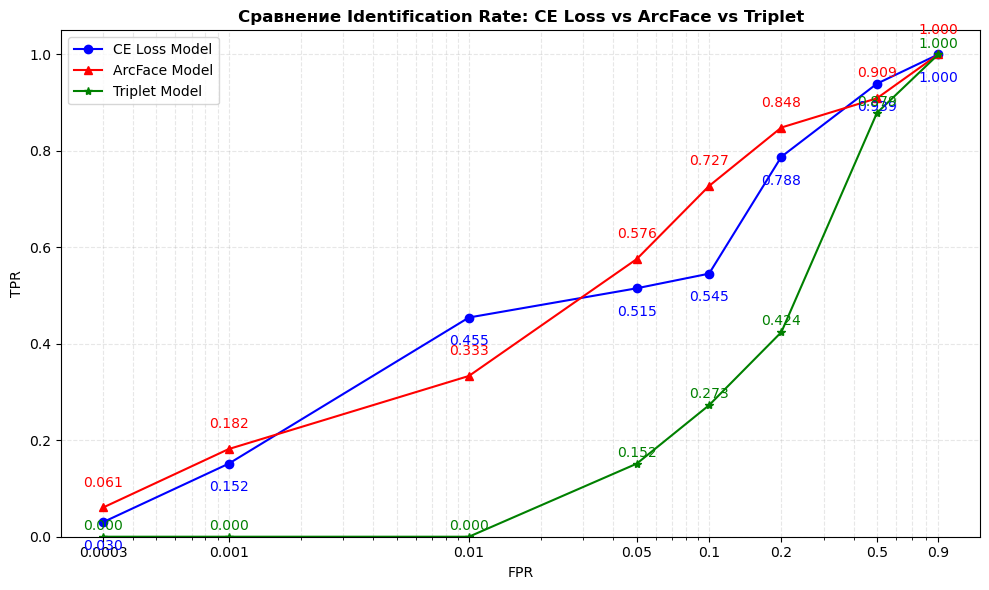

In [48]:
# извлекаем из списков нужные значения для графика
fpr_ce = [r[0] for r in results_ce]
tpr_ce = [r[2] for r in results_ce]

fpr_af = [r[0] for r in results_arcface]
tpr_af = [r[2] for r in results_arcface]

fpr_tr = [r[0] for r in results_triplet]
tpr_tr = [r[2] for r in results_triplet]


# визуализация
plt.figure(figsize=(10, 6))
plt.plot(fpr_ce, tpr_ce, 'b-o', markersize=6, label='CE Loss Model')
plt.plot(fpr_af, tpr_af, 'r-^', markersize=6, label='ArcFace Model')
plt.plot(fpr_tr, tpr_tr, 'g-*', markersize=6, label='Triplet Model')

plt.xscale('log') # логарифмическая шкала по оси X для наглядности соотношения между кривыми классификации разными моделями
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Сравнение Identification Rate: CE Loss vs ArcFace vs Triplet', fontweight='bold')
plt.grid(True, alpha=0.3, which='both', linestyle='--')
plt.legend()

# отмечаем интересующие нас значения на оси X
plt.xticks(fpr_lst, [f'{v}' for v in fpr_lst])
plt.ylim(0, 1.05) # ограничения оси


# подписываем точки
# CE Loss
for fpr, tpr in zip(fpr_ce, tpr_ce):
    plt.annotate(f'{tpr:.3f}', 
                (fpr, tpr),
                textcoords="offset points",
                xytext=(0, -20),
                ha='center',
                color='blue')

# ArcFace
for fpr, tpr in zip(fpr_af, tpr_af):
    plt.annotate(f'{tpr:.3f}', 
                (fpr, tpr),
                textcoords="offset points",
                xytext=(0, 15),
                ha='center',
                color='red')

# Triplet
for fpr, tpr in zip(fpr_tr, tpr_tr):
    plt.annotate(f'{tpr:.3f}', 
                (fpr, tpr),
                textcoords="offset points",
                xytext=(0, 5),
                ha='center',
                color='green')

plt.tight_layout()
plt.show()

Площадь под кривой (AUC):
	CE Loss Model: 1.6410
	ArcFace Model: 1.6653
Итак, ArcFace лучше на 1.5%


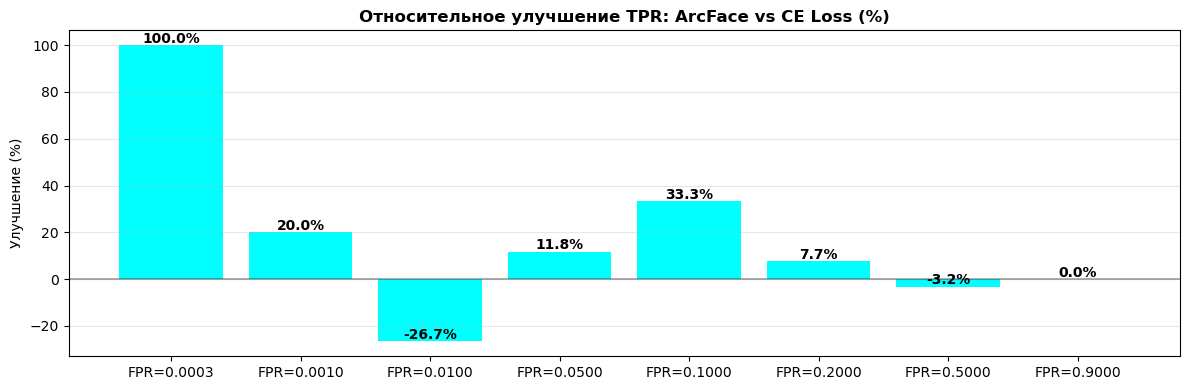

In [49]:
auc_ce = auc(np.log10(sorted(fpr_ce)), sorted(tpr_ce))
auc_af = auc(np.log10(sorted(fpr_af)), sorted(tpr_af))

print(f"Площадь под кривой (AUC):")
print(f"\tCE Loss Model: {auc_ce:.4f}")
print(f"\tArcFace Model: {auc_af:.4f}")
print(f"Итак, ArcFace лучше на {(auc_af - auc_ce) / auc_ce * 100:.1f}%")

# относительное улучшение для каждой расчетной точки
improvement = [(af - ce) / ce * 100 for af, ce in zip(tpr_af, tpr_ce)]

plt.figure(figsize=(12, 4))
plt.bar([f'FPR={fpr:.4f}' for fpr in fpr_ce], improvement, color='cyan')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.title('Относительное улучшение TPR: ArcFace vs CE Loss (%)', fontweight='bold')
plt.ylabel('Улучшение (%)')
plt.grid(axis='y', alpha=0.3)

for i, v in enumerate(improvement):
    plt.text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

## **Выводы**


Результаты показывают, что ArcFace не доминирует на всем диапазоне fpr, но в среднем, чем выше требование к ошибке (т.е. чем ниже fpr), тем ArcFace работает лучше, так как модель пытается развести ембендинги разных людей подальше друг от друга.

ArcFace отлично показывает себя при очень низких fpr, значит, ее можно использовать для критически важных областей, где цена ошибки в распознавании велика, например, банковские приложения, контроль доступа на территорию, и т.д.

Некоторый "провал" в качестве классификации при fpr=0.01 возможно вызван малым датасетом (не хватило разнообразия в пространстве признаков и одна модель в данной области пространства эмбеддингов ведет себя лучше).

Для улучшения характеристик обеих моделей или для более глубокого исследования необходимо подготовить более разнообразный датасет с бОльшим количеством изображений на каждую персону, также можно улучшить модель StackedHourglass для лучшего предсказания heatmaps, а, значит, и landmarks, ну и наконец, можно (нужно) взять более глубокую сеть для модели распознавания лиц (например, ResNet50)